In [117]:
import pandas as pd
import numpy as np

import time

from scipy.stats import randint

from collections import Counter

from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay, LearningCurveDisplay, GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.inspection import PartialDependenceDisplay

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

In [118]:
def pie_plot(df, feat):

    fig = px.pie(df, names = df[feat].values, hole = .75)
    fig.update_traces(pull = [0.05] * len(df),
                      textfont_color='white')

    fig.update_layout(title = {'text':f'&nbsp;&nbsp;<b>Распределение классов<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{feat}</i></sup></b>',
                                'x': 0, 'xanchor': 'left'},
                    margin=dict(t=100, r = 0),
                    template = 'seaborn',
                    showlegend = True,

                    height = 550, width = 650
                    )
    fig.show()

In [119]:
def boxplot_histogram(df, feat):

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=["Диаграмма размаха", "Гистограмма"],
        horizontal_spacing=0.2
    )

    fig.add_trace(go.Box(y=df[feat], name=""), row=1, col=1)
    fig.add_trace(go.Histogram(x=df[feat], name="Гистограмма"), row=1, col=2)

    fig.update_layout(template = 'seaborn',
                    margin = dict(t = 100),
                    showlegend = False,
                    height = 450, width = 1000
                )
    
    fig.update_yaxes(title_text=f"<b>{feat}</b>", row=1, col=1)
    
    fig.update_yaxes(title_text="<b>Частота</b>", row=1, col=2)
    fig.update_xaxes(title_text=f"<b>{feat}</b>", row=1, col=2)

    fig.show()

In [120]:
def plot_correlation(df):

    corr = np.round(df.corr(), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])


    
    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1])

    fig.update_layout(margin = dict(t=210, l = 110),
                    yaxis = dict(autorange = 'reversed', showgrid = False),
                    xaxis = dict(showgrid = False),
                    height = 950, width = 950)
                     

    fig.add_trace(go.Heatmap(z = c[::-1],
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 12

    fig.show()

In [121]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Low', 'Average', 'High']
    fig, ax = plt.subplots()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sb.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [122]:
df=pd.read_csv('Credit Score Classification Dataset.csv')
df.head(10)
RandomState=123

In [123]:
df_copy = df.copy()

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [125]:
pie_plot(df, 'Credit Score')

In [126]:
df_copy=pd.get_dummies(df_copy)
# df['Education'] = df['Education'].replace({'High School Diploma': 1, "Associate's Degree": 2, "Bachelor's Degree": 3, "Master's Degree": 4, "Doctorate": 5})
# df['Marital Status'] = df['Marital Status'].replace({'Single': 1, "Married": 2})
# df['Home Ownership'] = df['Home Ownership'].replace({'Owned': 1, "Rented": 0})
# df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
# df['Credit Score'] = df['Credit Score'].replace({'Low': 1, 'Average': 2, 'High': 3})

plot_correlation(df_copy)

In [127]:
for feat in df.columns.to_list():
    boxplot_histogram(df, feat)

In [128]:
# Удаляем наименее влиятельные признаки
X=df.drop('Credit Score',axis=1)
X=df.drop('Age',axis=1)
X=df.drop('Gender',axis=1)
X=df.drop('Education',axis=1)
X=df.drop('Number of Children',axis=1)
# Кодируем категориальные признаки
X=pd.get_dummies(X)
y=df['Credit Score']
# Применяем Oversampling
sm = SMOTE(random_state=RandomState)
X,y=sm.fit_resample(X, y)
# Разделяем на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=RandomState)

In [129]:
print('Original dataset shape %s' % Counter(y))
print('Original dataset shape %s' % Counter(y_test))
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({'High': 113, 'Average': 113, 'Low': 113})
Original dataset shape Counter({'Average': 40, 'Low': 34, 'High': 28})
Original dataset shape Counter({'High': 85, 'Low': 79, 'Average': 73})


In [130]:
print('Original dataset shape %s' % Counter(X))
print('Original dataset shape %s' % Counter(X_test))
print('Original dataset shape %s' % Counter(X_train))

Original dataset shape Counter({'Age': 1, 'Income': 1, 'Gender_Female': 1, 'Gender_Male': 1, "Education_Associate's Degree": 1, "Education_Bachelor's Degree": 1, 'Education_Doctorate': 1, 'Education_High School Diploma': 1, "Education_Master's Degree": 1, 'Marital Status_Married': 1, 'Marital Status_Single': 1, 'Home Ownership_Owned': 1, 'Home Ownership_Rented': 1, 'Credit Score_Average': 1, 'Credit Score_High': 1, 'Credit Score_Low': 1})
Original dataset shape Counter({'Age': 1, 'Income': 1, 'Gender_Female': 1, 'Gender_Male': 1, "Education_Associate's Degree": 1, "Education_Bachelor's Degree": 1, 'Education_Doctorate': 1, 'Education_High School Diploma': 1, "Education_Master's Degree": 1, 'Marital Status_Married': 1, 'Marital Status_Single': 1, 'Home Ownership_Owned': 1, 'Home Ownership_Rented': 1, 'Credit Score_Average': 1, 'Credit Score_High': 1, 'Credit Score_Low': 1})
Original dataset shape Counter({'Age': 1, 'Income': 1, 'Gender_Female': 1, 'Gender_Male': 1, "Education_Associate'

Время обучения модели: 0.0240 секунд


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



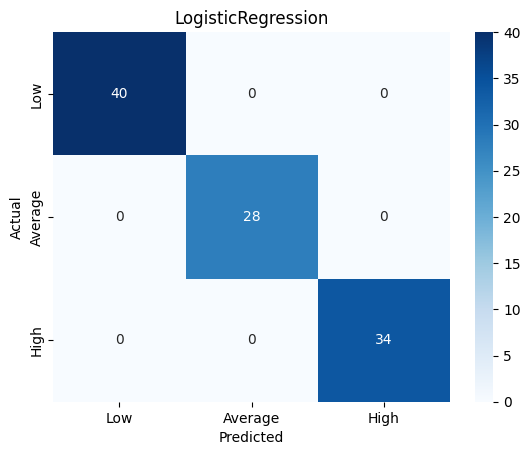

              precision    recall  f1-score   support

     Average       1.00      1.00      1.00        40
        High       1.00      1.00      1.00        28
         Low       1.00      1.00      1.00        34

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

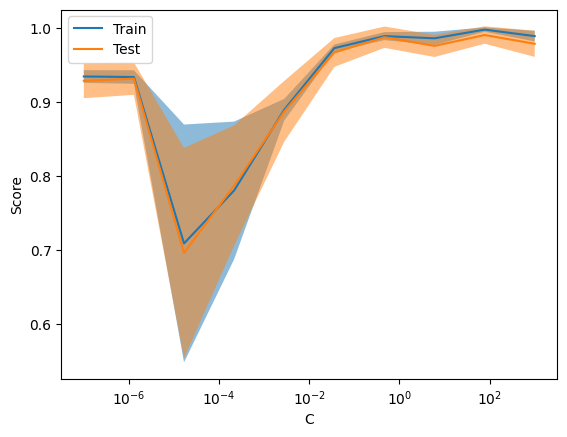

In [131]:
start_time = time.time()
log_reg_model=LogisticRegression(random_state=RandomState).fit(X_train,y_train)
print("Время обучения модели: {:.4f} секунд".format(time.time()-start_time))

y_pred = log_reg_model.predict(X_test)

plot_confusion_matrix(y_test,y_pred,"LogisticRegression")

print(classification_report(y_pred,y_test))
ValidationCurveDisplay.from_estimator(log_reg_model,X,y,param_name='C',param_range=np.logspace(-7,3,10))

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

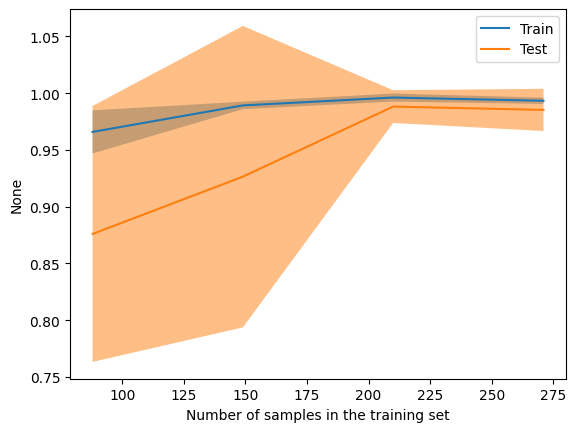

In [132]:
train_sizes, train_scores,test_scores=learning_curve(log_reg_model,X,y)
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()
plt.show()

Время обучения модели: 0.0060 секунд


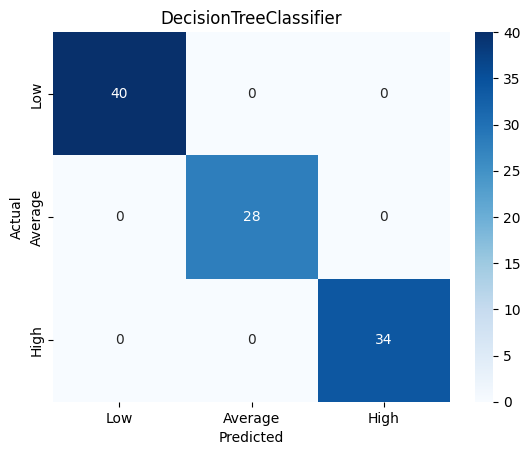

              precision    recall  f1-score   support

     Average       1.00      1.00      1.00        40
        High       1.00      1.00      1.00        28
         Low       1.00      1.00      1.00        34

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



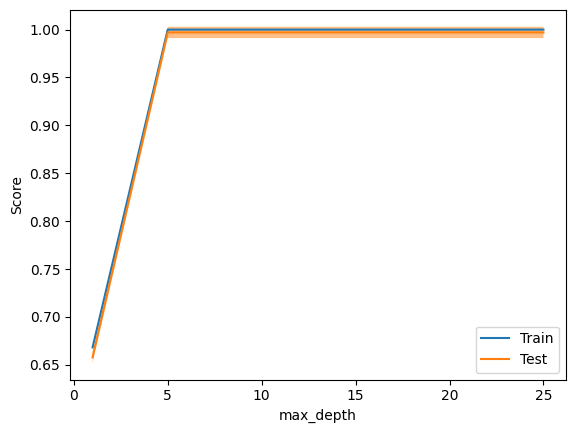

In [133]:
start_time=time.time()
d_tree_model=DecisionTreeClassifier(random_state=RandomState).fit(X_train,y_train)
print("Время обучения модели: {:.4f} секунд".format(time.time()-start_time))

y_pred = d_tree_model.predict(X_test)

plot_confusion_matrix(y_test,y_pred,"DecisionTreeClassifier")

print(classification_report(y_pred,y_test))
ValidationCurveDisplay.from_estimator(d_tree_model,X,y,param_name='max_depth',param_range=[1,5,6,9,10,12,15,20,25])

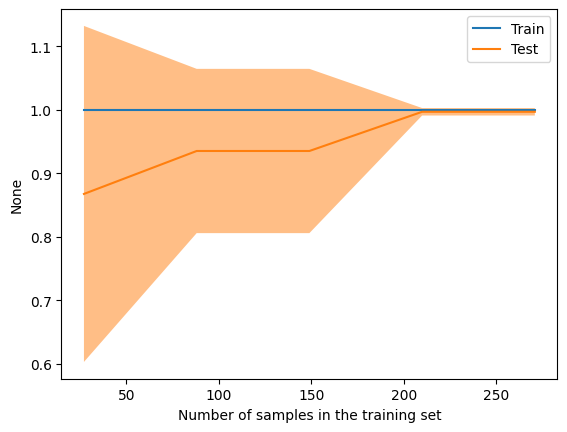

In [134]:
train_sizes, train_scores,test_scores=learning_curve(d_tree_model,X,y)
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()
plt.show()

Время обучения модели: 0.0050 секунд


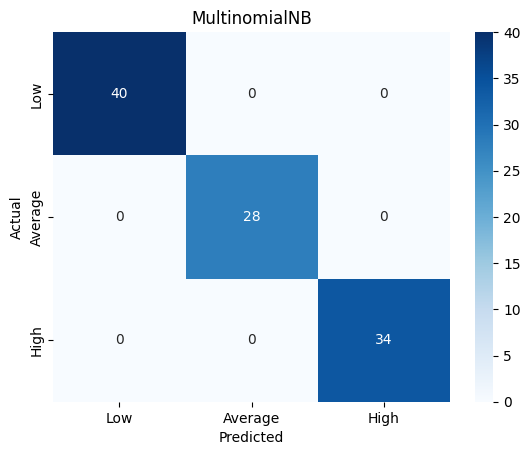

              precision    recall  f1-score   support

     Average       1.00      1.00      1.00        40
        High       1.00      1.00      1.00        28
         Low       1.00      1.00      1.00        34

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



In [135]:
start_time=time.time()
M_NB_model=MultinomialNB().fit(X_train,y_train)
print("Время обучения модели: {:.4f} секунд".format(time.time()-start_time))

y_pred = M_NB_model.predict(X_test)

plot_confusion_matrix(y_test,y_pred,"MultinomialNB")

print(classification_report(y_pred,y_test))


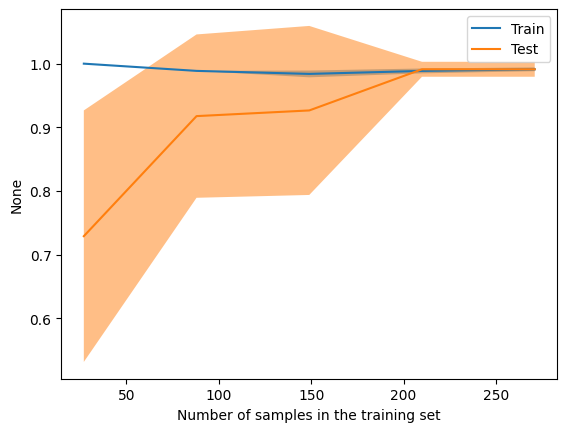

In [136]:
train_sizes, train_scores,test_scores=learning_curve(M_NB_model,X,y)
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()
plt.show()

Время обучения модели: 0.0050 секунд


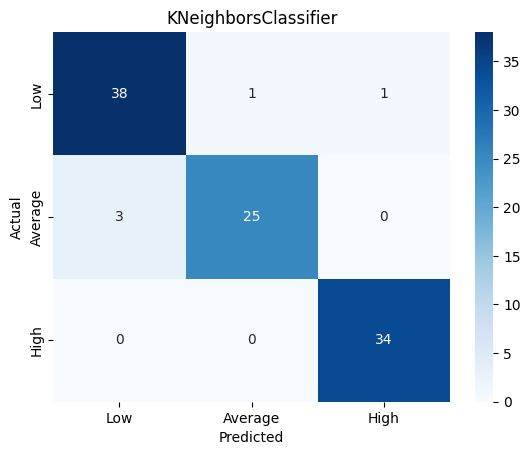

              precision    recall  f1-score   support

     Average       0.95      0.93      0.94        41
        High       0.89      0.96      0.93        26
         Low       1.00      0.97      0.99        35

    accuracy                           0.95       102
   macro avg       0.95      0.95      0.95       102
weighted avg       0.95      0.95      0.95       102



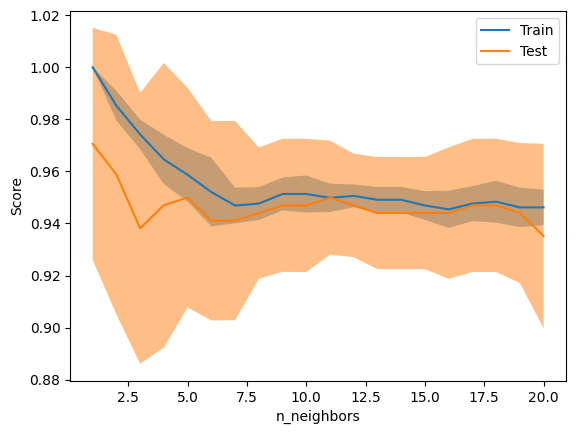

In [137]:
start_time=time.time()
KN_model=KNeighborsClassifier().fit(X_train,y_train)
print("Время обучения модели: {:.4f} секунд".format(time.time()-start_time))

y_pred = KN_model.predict(X_test)

plot_confusion_matrix(y_test,y_pred,"KNeighborsClassifier")

print(classification_report(y_pred,y_test))
ValidationCurveDisplay.from_estimator(KN_model,X,y,param_name='n_neighbors',param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

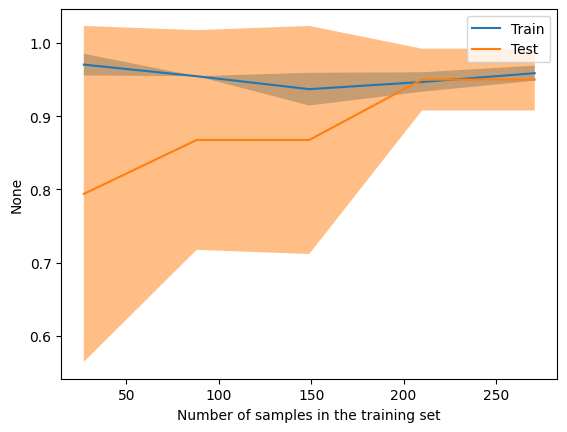

In [138]:
train_sizes, train_scores,test_scores=learning_curve(KN_model,X,y)
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()
plt.show()

In [139]:
rs_space={'C':np.logspace(-7,3,10),
               # 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma':['scale', 'auto']
         }

Время обучения модели: 0.0040 секунд


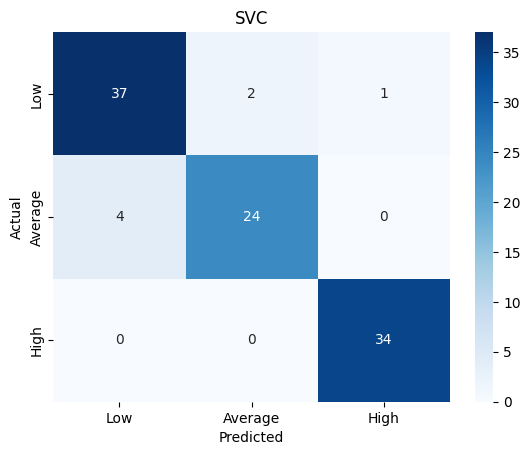

              precision    recall  f1-score   support

     Average       0.93      0.90      0.91        41
        High       0.86      0.92      0.89        26
         Low       1.00      0.97      0.99        35

    accuracy                           0.93       102
   macro avg       0.93      0.93      0.93       102
weighted avg       0.93      0.93      0.93       102

[1.00000000e-07 1.29154967e-06 1.66810054e-05 2.15443469e-04
 2.78255940e-03 3.59381366e-02 4.64158883e-01 5.99484250e+00
 7.74263683e+01 1.00000000e+03]


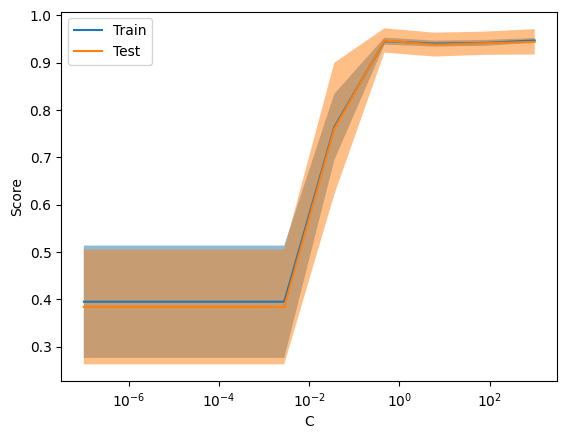

In [140]:
start_time=time.time()
SVC_model=SVC(C=5.99484250,random_state=RandomState).fit(X_train,y_train)
# random_search=RandomizedSearchCV(SVC_model, rs_space,n_iter=100)
# random_search_model=random_search.fit(X_train,y_train)
print("Время обучения модели: {:.4f} секунд".format(time.time()-start_time))
# print('Best hyperparameters are: '+str(random_search_model.best_params_))
# print('Best score is: '+str(random_search_model.best_score_))

y_pred = SVC_model.predict(X_test)

plot_confusion_matrix(y_test,y_pred,"SVC")

print(classification_report(y_pred,y_test))

ValidationCurveDisplay.from_estimator(SVC_model,X,y,param_name='C',param_range=np.logspace(-7,3,10))
print(np.logspace(-7,3,10))

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PC\AppData\Local\Progr

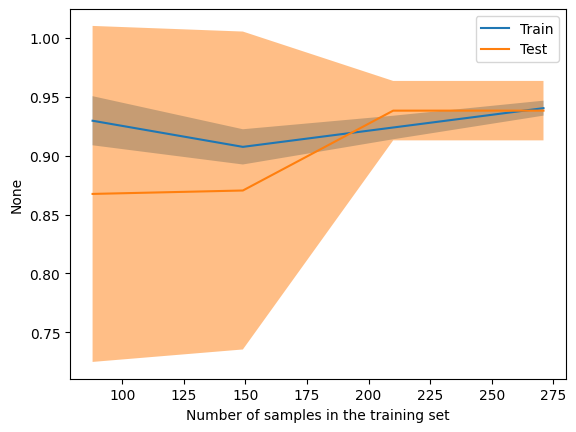

In [141]:
train_sizes, train_scores,test_scores=learning_curve(SVC_model,X,y)
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()
plt.show()